# Tariff Recommendation

We have data on the behavior of customers of mobile operator "Megaline", who switched to tariffs "Smart" and "Ultra".

We need to build a model for the *classification problem* with the largest possible *accuracy* value (at least 0.75), capable of analyzing the behavior of customers and offering a new tariff: "Smart" or "Ultra" to the users using the archived tariffs. 

# Data description

- calls: The number of calls.
- minutes: The total duration of calls in minutes.
- messages: The number of SMS messages.
- mb_used: The amount of used Internet traffic in megabytes (Mb).
- is_ultra: A binary indicator for the tariff used during the month, where "Ultra" is represented by 1 and "Smart" by 0.

## Exploring the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


There are no missing values. The column names do not need to be corrected.

Replace the data types in the 'calls' and 'messages' columns with int, since the data in these columns are integers:

In [5]:
df = df.astype({'calls': 'int64', 'messages': 'int64'})

#df.info()

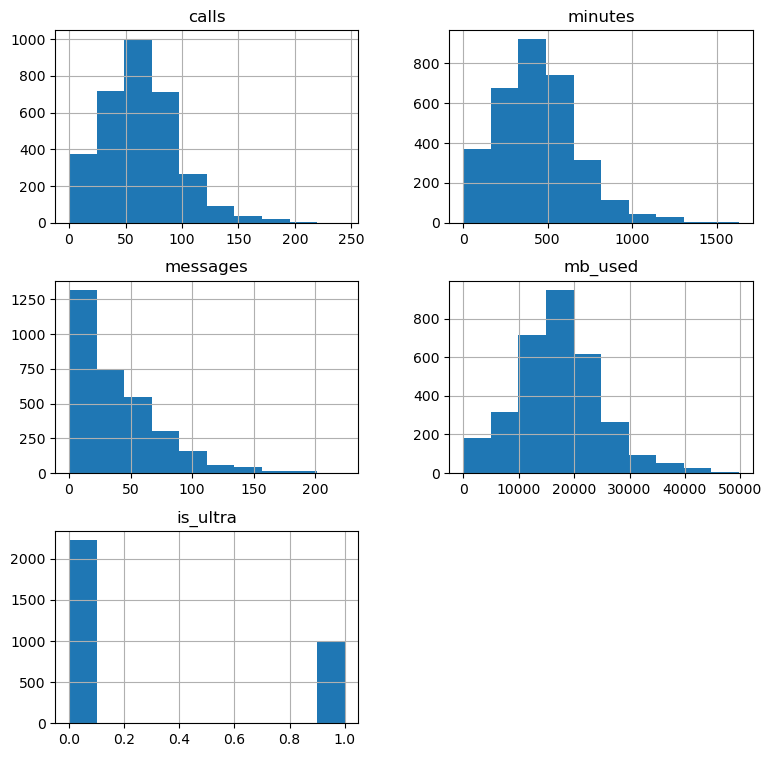

In [6]:
df.hist(figsize=(9, 9));

According to the histograms we can conclude that most subscribers of the presented data set:

- makes about 60 calls monthly totaling approximately 400 minutes;
- sends about 30 sms-messages monthly;
- consumes about 20 thousand mb of Internet traffic;
- prefers the "Smart" tariff to the "Ultra" tariff.

Let's check the data for multicollinearity:

In [7]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


the 'calls' and 'minutes' columns have a correlation coefficient of 0.98. The influence is strong, the relationship is direct. Let's remove the 'minutes' column from the set:

In [8]:
df = df.drop(['minutes'], axis=1)

Let's use the pairplot method to see how the values of the target feature "is_ultra" are distributed:

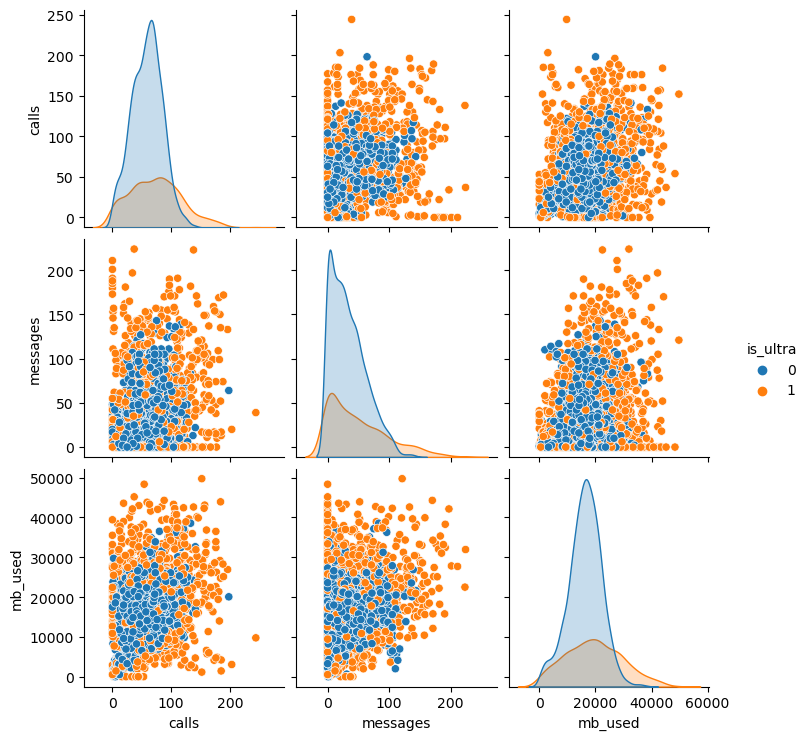

In [9]:
sns.pairplot(df, hue="is_ultra");

After outputting the graph we see that on average:

- subscribers with "Smart" tariff make about 250 calls monthly, while subscribers with "Ultra" tariff - about 50;

- subscribers with "Smart" tariff send more than 200 sms-messages monthly, while subscribers with "Ultra" tariff - about 50;

- subscribers with "Smart" tariff use about 50 thousand mb of Internet traffic, subscribers with "Ultra" tariff - about 10 thousand mb.

## Sampling

Let's divide the data into samples. Taking into account that only the original dataset is available to us, let's divide the data according to the 3:1:1 scenario (60% of the data will be left for the training sample, 20% for the test sample, and 20% for the validation sample).

In [10]:
df_train, df_test = train_test_split(df, test_size=0.4, random_state=12345)

In [11]:
df_test, df_valid = train_test_split(df_test, test_size=0.5, random_state=12345) 

Now create variables for features and target for all samples. We will use the 'is_ultra' column as the target. 

In [12]:
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra'] 

In [13]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)
print(features_valid.shape)
print(target_valid.shape)

(1928, 3)
(1928,)
(643, 3)
(643,)
(643, 3)
(643,)


So, we got samples of 1928 items for training, 643 items for testing and 643 for vadidation.

## Model Exploration

Let's start by building a *decision tree model*.

In [14]:
best_model = None
best_result = 0

# find the optimal depth and the best result:
for depth in range(1, 11):
    
    # create a model object of the decision tree data structure:
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    
    # train the model on the training sample data:
    model.fit(features_train, target_train)
    
    # make predictions on the validation sample data:
    predictions_valid = model.predict(features_valid)
    
    # check the quality of the model on the validation sample data:
    accuracy_valid = accuracy_score(target_valid, predictions_valid) 
    
    if accuracy_valid > best_result:
        
        # keep the best model
        best_model = model
        
        # save the best accuracy metric
        best_result = accuracy_valid
        
        # save the best depth value
        best_depth = depth
        
print("Accuracy of the best model on the training sample:", best_result, ", depth of the best model:", depth)

Accuracy of the best model on the training sample: 0.7947122861586314 , depth of the best model: 10


Moving on to the *random forest model*:

In [15]:
best_model = None
best_result = 0

for est in range(10, 200, 5):
    
    # create a model with the given number of trees:
    model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    
    # train it on the training sample
    model.fit(features_train, target_train) 
    
    # make predictions on the validation sample data:
    predictions_valid = model.predict(features_valid)
    
    # check the quality of the model on the validation sample data:
    accuracy_valid = accuracy_score(target_valid, predictions_valid) 
    
    if accuracy_valid > best_result:
        
        # keep the best model
        best_model = model
        
        # save the best accuracy metric
        best_result = accuracy_valid
        
        # save the best value for the number of trees
        best_est = est

print("Accuracy of the best model on the training sample:", best_result, ", n_estimators of the best model:", best_est)

Accuracy of the best model on the training sample: 0.7978227060653188 , n_estimators of the best model: 20


Let's check how the *logistic regression model* performs:

In [16]:
# create a model
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)

# train it on the training sample
model.fit(features_train, target_train)

# make predictions on the validation sample data:
predictions_valid = model.predict(features_valid)
  
# check the quality of the model on the validation sample data:
accuracy_valid = accuracy_score(target_valid, predictions_valid)
 
    
print ("Accuracy of the model on the training sample:", accuracy_valid)

Accuracy of the model on the training sample: 0.6936236391912908


Accuracy is the most important criterion for business: the higher the quality, the more profit the product brings.

On the training sample data, the highest accuracy index (0.798) was shown by the random forest model with the number of trees 20.

The accuracy on the training sample of the decision tree model was 0.795 with a depth of 10. Considering that the learning tree model is prone to overtraining (or undertraining) when the depth is changed and that the random forest model showed the best result, we prefer the random forest model.

The logistic regression model has the lowest accuracy index of 0.694. Increasing the max_iter parameter to 1000 did not increase the accuracy. This model will have to be abandoned.

## Validation of the model on a test sample

In [17]:
model = RandomForestClassifier(random_state=12345, n_estimators=20) 
    
# train it on the training sample
model.fit(features_train, target_train) 

# make predictions on the test sample data:
predictions_test = model.predict(features_test)
    
# check the quality of the model on the test sample
accuracy_test = accuracy_score(target_test, predictions_test)

accuracy_test

0.7807153965785381

On the test sample, the quality of the random forest model decreased to 0.780, but the value remained within acceptable limits.

## Checking the model for adequacy

Let's compare the accurancy of the obtained model with the answers of the model that predicts all objects randomly. With 50/50 probability the answer will be 0 or 1.

accuracy_random = [(quantity 1 * proportion of guessed 1) + (quantity 0 * proportion of guessed 0)] / number of objects


In [18]:
# number of units (the "Ultra" tariff is selected):
q_1 = len(df_train.loc[df_train['is_ultra']==1]['is_ultra'])

# number of zeros (the "Smart" tariff is selected):
q_0 = len(df_train.loc[df_train['is_ultra']==0]['is_ultra'])

# number of objects in the training sample:
q = len(df_train['is_ultra'])

# estimation of the quality of the random model:
accuracy_random = (q_1 * 0.5 + q_0 * 0.5)/q

print ('Accurancy of the random model is:', accuracy_random)

Accurancy of the random model is: 0.5


The quality of the model we obtained is higher than that of the random model. Let's check the quality of the model on the validation sample data:

In [19]:
dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(features_train, target_train)

DummyClassifier(strategy='most_frequent')

dummy_predict = dummy_clf.predict(features_test)

dummy_clf.score(dummy_predict, target_test)

0.7060653188180405

In [20]:
dummy_clf.score(features_test, target_test)

0.7060653188180405

# Conclusion

In the research process, the dataset was divided into three samples: training, test, and validation samples in the ratio of 60-20-20.

Based on the training sample, three models were tested: decision tree, random forest, and logistic regression. Out of these models, the random forest model was selected because it exhibited the best quality results.

Furthermore, the parameters of depth and the number of trees were chosen based on their performance on the test sample data.

The model's adequacy was also assessed, and it was validated using the test sample.

As a result, we obtained a model with the highest achievable accuracy value (0.780) on the validation sample data. This model is capable of analyzing customer behavior and recommending a new tariff, either "Smart" or "Ultra," to users who are currently using archived tariffs.